# Introduction to PyMC3


Probabilistic programming (PP) allows flexible specification of Bayesian statistical models in code. PyMC3 is a new, open-source PP framework with an intuitive and readable, yet powerful, syntax that is close to the natural syntax statisticians use to describe models. It features next-generation Markov chain Monte Carlo (MCMC) sampling algorithms such as the No-U-Turn Sampler (NUTS; Hoffman, 2014), a self-tuning variant of Hamiltonian Monte Carlo (HMC; Duane, 1987). This class of samplers works well on high dimensional and complex posterior distributions and allows many complex models to be fit without specialized knowledge about fitting algorithms. HMC and NUTS take advantage of gradient information from the likelihood to achieve much faster convergence than traditional sampling methods, especially for larger models. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo, which means you usually don't need to have specialized knowledge about how the algorithms work. PyMC3, Stan (Stan Development Team, 2014), and the LaplacesDemon package for R are currently the only PP packages to offer HMC.

### PyMC3 Features

Probabilistic programming in Python confers a number of advantages including multi-platform compatibility, an expressive yet clean and readable syntax, easy integration with other scientific libraries, and extensibility via C, C++, Fortran or Cython. These features make it relatively straightforward to write and use custom statistical distributions, samplers and transformation functions, as required by Bayesian analysis.

PyMC3's feature set helps to make Bayesian analysis as painless as possible. Here is a short list of some of its features:

-   Fits Bayesian statistical models with Markov chain Monte Carlo, variational inference and
    other algorithms.
-   Includes a large suite of well-documented statistical distributions.
-   Creates summaries including tables and plots.
-   Traces can be saved to the disk as plain text, SQLite or pandas dataframes.
-   Several convergence diagnostics and model checking methods are available.
-   Extensible: easily incorporates custom step methods and unusual probability distributions.
-   MCMC loops can be embedded in larger programs, and results can be analyzed with the full power of Python.

Here, we present a primer on the use of PyMC3 for solving general Bayesian statistical inference and prediction problems. We will first see the basics of how to use PyMC3, motivated by a simple example: installation, data creation, model definition, model fitting and posterior analysis. Then we will cover two case studies and use them to show how to define and fit more sophisticated models. Finally we will show how to extend PyMC3 and discuss other useful features: the Generalized Linear Models subpackage, custom distributions, custom transformations and alternative storage backends.

In [1]:
%load ../data/melanoma_data.py

In [2]:
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from pymc3 import Normal, Model, DensityDist, sample, log, exp

with Model() as melanoma_survival:

    # Convert censoring indicators to indicators for failure event
    failure = (censored==0).astype(int)

    # Parameters (intercept and treatment effect) for survival rate
    beta = Normal('beta', mu=0.0, sd=1e5, shape=2)

    # Survival rates, as a function of treatment
    lam = exp(beta[0] + beta[1]*treat)
    
    # Survival likelihood, accounting for censoring
    def logp(failure, value):
        return (failure * log(lam) - lam * value).sum()

    x = DensityDist('x', logp, observed={'failure':failure, 'value':t})


This example will generate 1000 posterior samples.

In [3]:
with melanoma_survival:
    trace = sample(1000)

Assigned NUTS to beta
 [-----------------100%-----------------] 1000 of 1000 complete in 0.5 sec

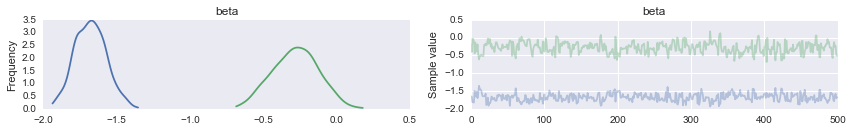

In [4]:
from pymc3 import traceplot

traceplot(trace[500:], varnames=['beta']);

## Motivating Example: Coal mining disasters

Consider the following time series of recorded coal mining disasters in the UK from 1851 to 1962 (Jarrett, 1979). The number of disasters is thought to have been affected by changes in safety regulations during this period.

Let's build a model for this series and attempt to estimate when the change occurred.

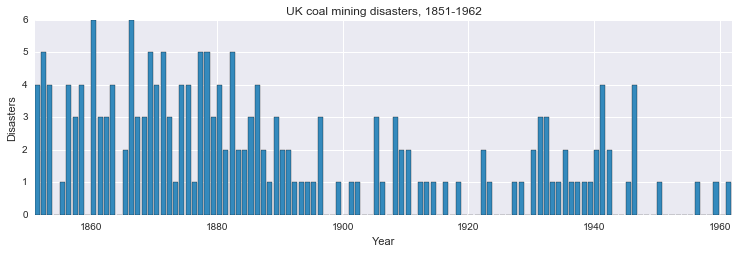

In [12]:
import numpy as np
import matplotlib.pyplot as plt

disasters_data = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                         3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                         2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                         1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                         0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                         3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                         0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

n_years = len(disasters_data)

plt.figure(figsize=(12.5, 3.5))
plt.bar(np.arange(1851, 1962), disasters_data, color="#348ABD")
plt.xlabel("Year")
plt.ylabel("Disasters")
plt.title("UK coal mining disasters, 1851-1962")
plt.xlim(1851, 1962);

We represent our conceptual model formally as a statistical model:

$$\begin{array}{ccc}  
(y_t | \tau, \lambda_1, \lambda_2) \sim\text{Poisson}\left(r_t\right), & r_t=\left\{
\begin{array}{lll}             
\lambda_1 &\text{if}& t< \tau\\ 
\lambda_2 &\text{if}& t\ge \tau             
\end{array}\right.,&t\in[t_l,t_h]\\         
\tau \sim \text{DiscreteUniform}(t_l, t_h)\\         
\lambda_1\sim \text{Exponential}(a)\\         
\lambda_2\sim \text{Exponential}(b)     
\end{array}$$

Because we have defined $y$ by its dependence on $\tau$, $\lambda_1$ and $\lambda_2$, the latter three are known as the *parents* of $y$ and $D$ is called their *child*. Similarly, the parents of $\tau$ are $t_l$ and $t_h$, and $\tau$ is the child of $t_l$ and $t_h$.

## Implementing a PyMC Model

At the model-specification stage (before the data are observed), $y$, $\tau$, $\lambda_1$, and $\lambda_2$ are all random variables. Bayesian "random" variables have not necessarily arisen from a physical random process. The Bayesian interpretation of probability is *epistemic*, meaning random variable $x$'s probability distribution $p(x)$ represents our knowledge and uncertainty about $x$'s value. Candidate values of $x$ for which $p(x)$ is high are relatively more probable, given what we know. 

We can generally divide the variables in a Bayesian model into two types: *stochastic* and *deterministic*. The only deterministic variable in this model is $r$. If we knew the values of $r$'s parents, we could compute the value of $r$ exactly. A deterministic like $r$ is defined by a mathematical function that returns its value given values for its parents. Deterministic variables are sometimes called the *systemic* part of the model. The nomenclature is a bit confusing, because these objects usually represent random variables; since the parents of $r$ are random, $r$ is random also.

On the other hand, even if the values of the parents of variables `switchpoint`, `disasters` (before observing the data), `early_mean` or `late_mean` were known, we would still be uncertain of their values. These variables are stochastic, characterized by probability distributions that express how plausible their candidate values are, given values for their parents.

Let's begin by defining the unknown switchpoint as a discrete uniform random variable:

In [13]:
from pymc3 import DiscreteUniform

with Model() as disaster_model:

    switchpoint = DiscreteUniform('switchpoint', lower=0, upper=n_years)

We have done two things here. First, we have created a `Model` object; a `Model` is a Python object that encapsulates all of the variables that comprise our theoretical model, keeping them in a single container so that they may be used as a unit. After a `Model` is created, we can populate it with all of the model components that we specified when we wrote the model down. 

Notice that the `Model` above was declared using a `with` statement. This expression is used to define a Python idiom known as a **context manager**. Context managers, in general, are used to manage resources of some kind within a program. In this case, our resource is a `Model`, and we would like to add variables to it so that we can fit our statistical model. The key characteristic of the context manager is that the resources it manages are only defined within the indented block corresponding to the `with` statement. PyMC uses this idiom to automatically add defined variables to a model. Thus, any variable we define is automatically added to the `Model`, without having to explicitly add it. This avoids the repetitive syntax of `add` methods/functions that you see in some machine learning packages:

```python
model.add(a_variable)
model.add(another_variable)
model.add(yet_another_variable)
model.add(and_again)
model.add(please_kill_me_now)
...
```

In fact, PyMC variables cannot be defined without a corresponding `Model`:

In [14]:
foo = DiscreteUniform('foo', lower=0, upper=10)

TypeError: No model on context stack, which is needed to use the Normal('x', 0,1) syntax. Add a 'with model:' block

However, variables can be explicitly added to models without the use of a context manager, via the variable's optional `model` argument.

```python
disaster_model = Model()
switchpoint = DiscreteUniform('switchpoint', lower=0, upper=110, model=disaster_model)
```

Or, if we just want a discrete uniform distribution, and do not need to use it in a PyMC3 model necessarily, we can create one using the `dist` classmethod.

In [15]:
x = DiscreteUniform.dist(lower=0, upper=100)

In [16]:
x

`DiscreteUniform` is an object that represents uniformly-distributed discrete variables. Use of this distribution
suggests that we have no preference *a priori* regarding the location of the switchpoint; all values are equally likely. 

PyMC3 includes most of the common random variables used for statistical modeling. For example, the following discrete random variables are available.

In [17]:
from pymc3 import discrete
discrete.__all__

['Binomial',
 'BetaBinomial',
 'Bernoulli',
 'Poisson',
 'NegativeBinomial',
 'ConstantDist',
 'ZeroInflatedPoisson',
 'DiscreteUniform',
 'Geometric',
 'Categorical']

By having a library of variables that represent statistical distributions, users are relieved of having to code distrbutions themselves. 

Similarly, we can create the exponentially-distributed variables `early_mean` and `late_mean` for the early and late Poisson rates, respectively (also in the context of the model `distater_model`):

In [18]:
from pymc3 import Exponential

with disaster_model:
    
    early_mean = Exponential('early_mean', 1)
    late_mean = Exponential('late_mean', 1)

Applied log-transform to early_mean and added transformed early_mean_log to model.
Applied log-transform to late_mean and added transformed late_mean_log to model.


In this instance, we are told that the variables are being transformed. In PyMC3, variables with purely positive priors like `Exponential` are transformed with a log function. This makes sampling more robust. Behind the scenes, a variable in the unconstrained space (named "variableName_log") is added to the model for sampling. In this model this happens behind the scenes. Variables with priors that constrain them on two sides, like `Beta` or `Uniform` (continuous), are also transformed to be unconstrained but with a log odds transform.

Next, we define the variable `rate`, which selects the early rate `early_mean` for times before `switchpoint` and the late rate `late_mean` for times after `switchpoint`. We create `rate` using the `switch` function, which returns `early_mean` when the switchpoint is larger than (or equal to) a particular year, and `late_mean` otherwise.

In [20]:
from pymc3 import switch

with disaster_model:
    
    rate = switch(switchpoint >= np.arange(n_years), early_mean, late_mean)

The last step is to define the data likelihood, or sampling distribution. In this case, our measured outcome is the number of disasters in each year, `disasters`. This is a stochastic variable but unlike `early_mean` and `late_mean` we have *observed* its value. To express this, we set the argument `observed` to the observed sequence of disasters. This tells PyMC that this distribution's value is fixed, and should not be changed:

In [21]:
from pymc3 import Poisson

with disaster_model:
    
    disasters = Poisson('disasters', mu=rate, observed=disasters_data)

The model that we specified at the top of the page has now been fully implemented in PyMC3. Let's have a look at the model's attributes to see what we have.

The stochastic nodes in the model are identified in the `vars` (*i.e.* variables) attribute:

In [22]:
disaster_model.vars

[switchpoint, early_mean_log, late_mean_log]

The last two variables are the log-transformed versions of the early and late rate parameters. The original variables have become deterministic nodes in the model, since they only represent values that have been back-transformed from the transformed variable, which has been subject to fitting or sampling.

In [23]:
disaster_model.deterministics

[early_mean, late_mean]

You might wonder why `rate`, which is a deterministic component of the model, is not in this list. This is because, unlike the other components of the model, `rate` has not been given a name and given a formal PyMC data structure. It is essentially an intermediate calculation in the model, implying that we are not interested in its value when it comes to summarizing the output from the model. Most PyMC objects have a name assigned; these names are used for storage and post-processing:

-   as keys in on-disk databases,
-   as axis labels in plots of traces,
-   as table labels in summary statistics.

If we wish to include `rate` in our output, we need to make it a `Deterministic` object, and give it a name:

In [25]:
from pymc3 import Deterministic

with disaster_model:
    
    rate = Deterministic('rate', switch(switchpoint >= np.arange(n_years), early_mean, late_mean))

Now, `rate` is included in the `Model`'s deterministics list, and the model will retain its samples during MCMC sampling, for example.

In [26]:
disaster_model.deterministics

[early_mean, late_mean, rate]

### Why are data and unknown variables represented by the same object?

Since its represented by a `Stochastic` object, `disasters` is defined
by its dependence on its parent `rate` even though its value is fixed.
This isn't just a quirk of PyMC's syntax; Bayesian hierarchical notation
itself makes no distinction between random variables and data. The
reason is simple: to use Bayes' theorem to compute the posterior, we require the
likelihood. Even though `disasters`'s value is known
and fixed, we need to formally assign it a probability distribution as
if it were a random variable. Remember, the likelihood and the
probability function are essentially the same, except that the former is
regarded as a function of the parameters and the latter as a function of
the data.

This point can be counterintuitive at first, as many peoples' instinct
is to regard data as fixed a priori and unknown variables as dependent
on the data. One way to understand this is to think of statistical
modelsas predictive models for data, or as
models of the processes that gave rise to data. Before observing the
value of `disasters`, we could have sampled from its prior predictive
distribution $p(y)$ (*i.e.* the marginal distribution of the data) as
follows:

> -   Sample `early_mean`, `switchpoint` and `late_mean` from their
>     priors.
> -   Sample `disasters` conditional on these values.

Even after we observe the value of `disasters`, we need to use this
process model to make inferences about `early_mean` , `switchpoint` and
`late_mean` because its the only information we have about how the
variables are related.

## PyMC3 Variables

We have above created a PyMC probability model, which is simply a linked
collection of variables. To see the nature of the links, iexamine `switchpoint`'s `parents` attribute:

Each of the built-in statistical variables are subclasses of the generic `Distribution` class in PyMC3. The `Distribution` carries relevant attributes about the distribution, such as the data type (called `dtype`), any relevant transformations (`transform`, see below), and initial values (`testval`).

(array([ 105.,  116.,   96.,   96.,  103.,  110.,  103.,   85.,   84.,  102.]),
 array([   0.,   11.,   22.,   33.,   44.,   55.,   66.,   77.,   88.,
          99.,  110.]),
 <a list of 10 Patch objects>)

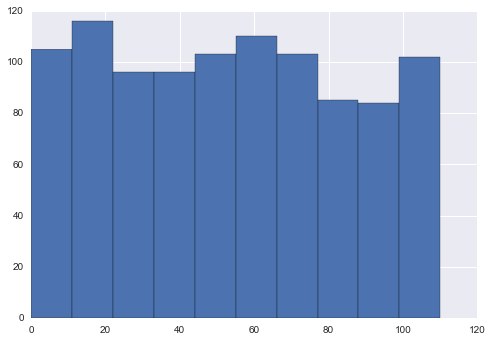

In [27]:
plt.hist(switchpoint.random(size=1000))

In [28]:
switchpoint.logp({'switchpoint':55, 'early_mean_log':1, 'late_mean_log':1})

array(-4.718498871295094)

The `parents` dictionary shows us the distributional parameters of
`switchpoint`, which are constants. Now let's examine \`disasters\`'s
parents:

In [34]:
disasters.dtype

'int64'

In [43]:
early_mean.transformed

early_mean_log

In [40]:
disaster_model.early_mean_log

early_mean_log

In [49]:
type(switchpoint)

pymc3.model.FreeRV

In [50]:
type(disasters)

pymc3.model.ObservedRV

In [51]:
switchpoint.distribution

## Variables' values and log-probabilities

All PyMC variables have an attribute called `value` that stores the
current value of that variable. Try examining `disasters`'s value, and
you'll see the initial value we provided for it:

In [ ]:
disasters.value

If you check the values of `early_mean`, `switchpoint` and `late_mean`,
you'll see random initial values generated by PyMC:

In [ ]:
switchpoint.value

In [ ]:
early_mean.value

In [ ]:
late_mean.value

Of course, since these are `Stochastic` elements, your values will be
different than these. If you check `rate`'s value, you'll see an array
whose first `switchpoint` elements are `early_mean`,
and whose remaining elements are `late_mean`:

In [ ]:
rate.value

To compute its value, `rate` calls the function we used to create it,
passing in the values of its parents.

`Stochastic` objects can evaluate their probability mass or density
functions at their current values given the values of their parents. The
logarithm of a stochastic object's probability mass or density can be
accessed via the `logp` attribute. For vector-valued variables like
`disasters`, the `logp` attribute returns the sum of the logarithms of
the joint probability or density of all elements of the value. Try
examining `switchpoint`'s and `disasters`'s log-probabilities and
`early_mean` 's and `late_mean`'s log-densities:

In [ ]:
switchpoint.logp

In [ ]:
disasters.logp

In [ ]:
early_mean.logp

In [ ]:
late_mean.logp

`Stochastic` objects need to call an internal function to compute their
`logp` attributes, as `rate` needed to call an internal function to
compute its value. Just as we created `rate` by decorating a function
that computes its value, it's possible to create custom `Stochastic`
objects by decorating functions that compute their log-probabilities or
densities. Users are thus not
limited to the set of of statistical distributions provided by PyMC.

## Theano

While most of PyMC3's user-facing features are written in pure Python, it leverages Theano (Bergstra et al., 2010) to transparently transcode models to C and compile them to machine code, thereby boosting performance. Theano is a library that allows expressions to be defined using generalized vector data structures called *tensors*, which are tightly integrated with the popular NumPy `ndarray` data structure, and similarly allow for broadcasting and advanced indexing, just as NumPy arrays do. Theano also automatically optimizes the likelihood's computational graph for speed and provides simple GPU integration.

## Fitting the model with MCMC

PyMC3's `sample` function will fit probability models (linked collections of variables) like ours using Markov chain Monte Carlo (MCMC) sampling. Unless specifically assigned particular algorithms, PyMC will assign algorithms that it deems appropriate for each variable in the model:

In [28]:
with disaster_model:
    trace = sample(2000)

Assigned Metropolis to switchpoint
Assigned NUTS to early_mean_log
Assigned NUTS to late_mean_log
 [-----------------100%-----------------] 2000 of 2000 complete in 1.1 sec

In [29]:
trace

<MultiTrace: 1 chains, 2000 iterations, 5 variables>

The `sample()` function always takes at least one argument, `draws`, which specifies how many samples to draw. However, there are a number of additional optional arguments that are worth knowing about:

In [99]:
help(sample)

Help on function sample in module pymc3.sampling:

sample(draws, step=None, start=None, trace=None, chain=0, njobs=1, tune=None, progressbar=True, model=None, random_seed=None)
    Draw a number of samples using the given step method.
    Multiple step methods supported via compound step method
    returns the amount of time taken.
    
    Parameters
    ----------
    
    draws : int
        The number of samples to draw
    step : function or iterable of functions
        A step function or collection of functions. If no step methods are
        specified, or are partially specified, they will be assigned
        automatically (defaults to None).
    start : dict
        Starting point in parameter space (or partial point)
        Defaults to trace.point(-1)) if there is a trace provided and
        model.test_point if not (defaults to empty dict)
    trace : backend, list, or MultiTrace
        This should be a backend instance, a list of variables to track,
        or a MultiTrac

### Accessing the samples

The output of the `sample` function is a `MultiTrace` object, which stores the sequence of samples for each variable in the model. These traces can be accessed using dict-style indexing:


In [30]:
trace['late_mean']

array([ 0.90723609,  0.90723609,  0.79127238, ...,  0.99009487,
        0.88605732,  1.03267273])

The trace can also be sliced using the NumPy array slice `[start:stop:step]`. 

In [31]:
trace['late_mean', 500:]

array([ 0.88679514,  0.88679514,  1.1536697 , ...,  0.99009487,
        0.88605732,  1.03267273])

### Sampling output

You can examine the marginal posterior of any variable by plotting a
histogram of its trace:

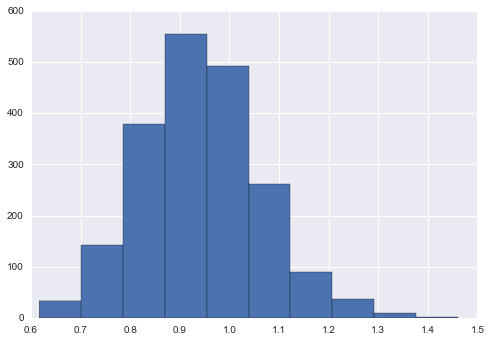

In [32]:
plt.hist(trace['late_mean']);

PyMC has its own plotting functionality dedicated to plotting MCMC output. For example, we can obtain a time series plot of the trace and a histogram using `traceplot`:

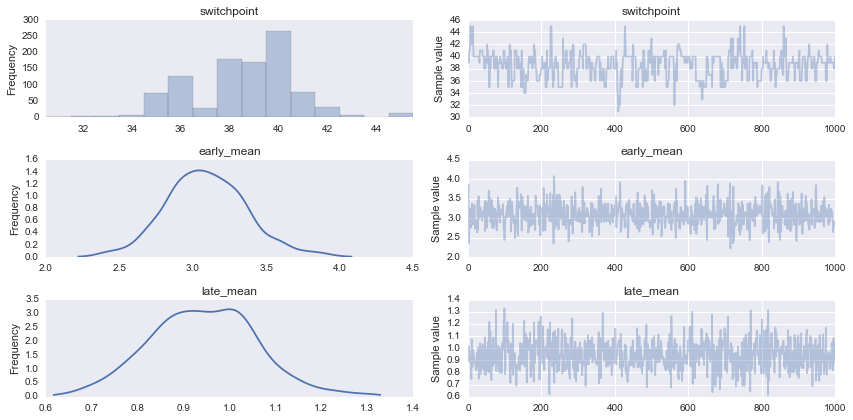

In [33]:
from pymc3 import traceplot

traceplot(trace[1000:]);

The upper left-hand pane of each figure shows the temporal series of the
samples from each parameter, while below is an autocorrelation plot of
the samples. The right-hand pane shows a histogram of the trace. The
trace is useful for evaluating and diagnosing the algorithm's
performance, while the histogram is useful for
visualizing the posterior.

For a non-graphical summary of the posterior, simply call the `stats` method.

In [34]:
from pymc3 import summary

summary(trace[1000:])


switchpoint:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  38.594           2.163            0.151            [35.000, 42.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  35.000         37.000         39.000         40.000         42.000


early_mean:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  3.093            0.277            0.009            [2.527, 3.635]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  2.574          2.908          3.081          3.278          3.684


late_mean:

  Mean             SD               MC Error         95% HPD interval
  -------

### Imputation of Missing Data

As with most textbook examples, the models we have examined so far
assume that the associated data are complete. That is, there are no
missing values corresponding to any observations in the dataset.
However, many real-world datasets have missing observations, usually due
to some logistical problem during the data collection process. The
easiest way of dealing with observations that contain missing values is
simply to exclude them from the analysis. However, this results in loss
of information if an excluded observation contains valid values for
other quantities, and can bias results. An alternative is to impute the
missing values, based on information in the rest of the model.

For example, consider a survey dataset for some wildlife species:

    Count   Site   Observer   Temperature
    ------- ------ ---------- -------------
    15      1      1          15
    10      1      2          NA
    6       1      1          11

Each row contains the number of individuals seen during the survey,
along with three covariates: the site on which the survey was conducted,
the observer that collected the data, and the temperature during the
survey. If we are interested in modelling, say, population size as a
function of the count and the associated covariates, it is difficult to
accommodate the second observation because the temperature is missing
(perhaps the thermometer was broken that day). Ignoring this observation
will allow us to fit the model, but it wastes information that is
contained in the other covariates.

In a Bayesian modelling framework, missing data are accommodated simply
by treating them as unknown model parameters. Values for the missing
data $\tilde{y}$ are estimated naturally, using the posterior predictive
distribution:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

This describes additional data $\tilde{y}$, which may either be
considered unobserved data or potential future observations. We can use
the posterior predictive distribution to model the likely values of
missing data.

Consider the coal mining disasters data introduced previously. Assume
that two years of data are missing from the time series; we indicate
this in the data array by the use of an arbitrary placeholder value,
`None`:

In [46]:
disasters_missing = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

To estimate these values in PyMC, we generate a *masked array*. These are specialised NumPy arrays that contain a matching True or False value for each element to indicate if that value should be excluded from any computation. Masked arrays can be generated using NumPy's `ma.masked_equal` function:

In [47]:
disasters_masked = np.ma.masked_values(disasters_missing, value=-999)
disasters_masked

masked_array(data = [4 5 4 0 1 4 3 4 0 6 3 3 4 0 2 6 3 3 5 4 5 3 1 4 4 1 5 5 3 4 2 5 2 2 3 4 2
 1 3 -- 2 1 1 1 1 3 0 0 1 0 1 1 1 0 1 0 1 0 0 0 2 1 0 0 0 1 1 0 2 3 3 1 --
 2 1 1 1 1 2 4 2 0 0 1 4 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1],
             mask = [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False],
       fill_value = -999)

This masked array, in turn, can then be passed to one of PyMC's data stochastic variables, which recognizes the masked array and replaces the missing values with stochastic variables of the desired type. For the coal mining disasters problem, recall that disaster events were modeled as Poisson variates:

```python
disasters = Poisson('disasters', mu=rate, observed=masked_values)
```

Each element in `disasters` is a Poisson random variable, irrespective of whether the observation was missing or not. The difference is that actual observations are assumed to be data stochastics, while the missing
values are unobserved stochastics. The latter are considered unknown, rather than fixed, and therefore estimated by the fitting algorithm, just as unknown model parameters are.

The entire model looks very similar to the original model:

In [61]:
with Model() as missing_data_model:

    # Prior for distribution of switchpoint location
    switchpoint = DiscreteUniform('switchpoint', lower=0, upper=len(disasters_masked))
    # Priors for pre- and post-switch mean number of disasters
    early_mean = Exponential('early_mean', lam=1.)
    late_mean = Exponential('late_mean', lam=1.)

    # Allocate appropriate Poisson rates to years before and after current
    # switchpoint location
    idx = np.arange(len(disasters_masked))
    rate = Deterministic('rate', switch(switchpoint >= idx, early_mean, late_mean))

    # Data likelihood
    disasters = Poisson('disasters', rate, observed=disasters_masked)

Applied log-transform to early_mean and added transformed early_mean_log to model.
Applied log-transform to late_mean and added transformed late_mean_log to model.


Here, we have used the `masked_array` function, rather than
`masked_equal`, and the value -999 as a placeholder for missing data.
The result is the same.

In [62]:
with missing_data_model:
    trace_missing = sample(2000)

Assigned Metropolis to switchpoint
Assigned NUTS to early_mean_log
Assigned NUTS to late_mean_log
Assigned Metropolis to disasters_missing
 [-----------------100%-----------------] 2000 of 2000 complete in 2.5 sec

In [63]:
missing_data_model.vars

[switchpoint, early_mean_log, late_mean_log, disasters_missing]

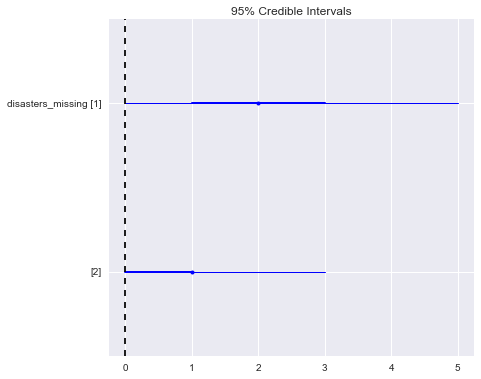

In [64]:
from pymc3 import forestplot

forestplot(trace_missing, varnames=['disasters_missing'])